In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
import hickle as hkl
x = hkl.load("test_x.hkl")
print(np.percentile(x[..., 0], 45) / 65535)

0.051606012054627295


In [179]:
from scipy.ndimage import label, grey_closing
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure
from scipy.ndimage.filters import gaussian_filter
import warnings
from scipy.ndimage import distance_transform_edt as distance
from scipy import signal
from scipy import ndimage

plt.figure(figsize=(12,10
                ))
x = np.load("../../src/mosaic.npy")
y = np.load("../../src/interp.npy")
t = np.load("../../src/tiles.npy")
a = np.load("../../src/after.npy")
c = np.load("../../src/cloudshad.npy")
from skimage.transform import resize

def detect_pfcp(arr):
    
    def _ndbi(arr):
        return ((arr[..., 8] - arr[..., 3]) / (arr[..., 8] + arr[..., 3]))
    
    def _ndvi(arr):
        return (arr[..., 3] - arr[..., 2]) / (arr[..., 3] + arr[..., 2])
    
    def _ndwi(arr):
        return (arr[..., 1] - arr[..., 3]) / (arr[..., 1] + arr[..., 3])
    
    pfps = np.logical_and(_ndbi(arr) > 0, _ndbi(arr) > _ndvi(arr))
    water_mask = _ndwi(arr)
    water_mask = np.median(water_mask, axis = 0)[np.newaxis]
    water_mask = water_mask > 0

    pfps = np.logical_and(pfps, water_mask == 0)
    
    cdis = np.zeros((arr.shape[0], arr.shape[1], arr.shape[2]), dtype = np.float32)
    
    for time in range(arr.shape[0]):
        
        b8down = np.copy(arr[time, ..., 3])
        if (b8down.shape[0] % 2 + b8down.shape[1] % 2) > 0:
            b8down = resize(b8down, (b8down.shape[0] + b8down.shape[0] % 2, 
                                     b8down.shape[1] + b8down.shape[1] % 2), 0)
        b8down = ndimage.gaussian_filter(b8down, sigma = 0.5, truncate = 3)
        b8down = np.reshape(b8down, (b8down.shape[0] // 2, 2, b8down.shape[1] // 2, 2))
        b8down = np.mean(b8down, axis = (1, 3))
        
        b8adown = np.copy(arr[time, ..., 7])
        if (b8adown.shape[0] % 2 + b8adown.shape[1] % 2) > 0:
            b8adown = resize(b8adown, (b8adown.shape[0] + b8adown.shape[0] % 2, 
                                       b8adown.shape[1] + b8adown.shape[1] % 2), 0)
        b8adown = np.reshape(b8adown, (b8adown.shape[0] // 2, 2, b8adown.shape[1] // 2, 2))
        b8adown = np.mean(b8adown, axis = (1, 3))
        
        b7down = np.copy(arr[time, ..., 6])
        if (b7down.shape[0] % 2 + b7down.shape[1] % 2) > 0:
            b7down = resize(b7down, (b7down.shape[0] + b7down.shape[0] % 2, 
                                           b7down.shape[1] + b7down.shape[1] % 2), 0)
        b7down = np.reshape(b7down, (b7down.shape[0] // 2, 2, b7down.shape[1] // 2, 2))
        b7down = np.mean(b7down, axis = (1, 3))
        
        r8a = b8down / b8adown
        r8a7 = b7down / b8adown

        mean_op = np.ones((7,7))/(7*7)
        mean_of_sq = signal.convolve2d( r8a**2, mean_op, mode='same', boundary='symm')
        sq_of_mean = signal.convolve2d( r8a   , mean_op, mode='same', boundary='symm') **2
        r8a = mean_of_sq - sq_of_mean

        mean_of_sq = signal.convolve2d( r8a7**2, mean_op, mode='same', boundary='symm')
        sq_of_mean = signal.convolve2d( r8a7   , mean_op, mode='same', boundary='symm') **2
        r8a7 = mean_of_sq - sq_of_mean

        cdi = (r8a7 -r8a)/(r8a7 + r8a)
        pfcps = cdi >= -0.7
        pfcps = pfcps.repeat(2, axis = 0).repeat(2, axis = 1)
        pfcps = resize(pfcps, (arr.shape[1], arr.shape[2]), 0)
        cdis[time] = pfcps
        
    cdis = binary_dilation(cdis, iterations = 3)
    pfps = binary_dilation(pfps, iterations = 3)
        
    fcps = (pfps * cdis)
    return fcps, pfps

def calculate_clouds_in_mosaic(mosaic, interp):
    # If there is only 1 availalble image, omission errors are
    # possible due to S2Cloudless and ESA SCL
    # We can assume that areas with > 1 image have no clouds,
    # as well as areas that we would consider false positives.
    # and use the red/blue band distributions of those areas
    # to threshold the non-saturated areas with 1 image
    # to make a cloud mask.
    only_1_img = np.sum(1 - (interp > 0), axis = 0).squeeze() < 2
    fcp, _ = detect_pfcp(mosaic[np.newaxis])
    fcp = binary_dilation(fcp, iterations = 10)
    
    only_1_img = np.maximum(only_1_img, fcp.squeeze())
    
    reference_blue = np.percentile(mosaic[..., 0][~only_1_img], 99)
    reference_red = np.percentile(mosaic[..., 2][~only_1_img], 99)
    print(reference_blue, reference_red)
    clouds_in_mosaic = ((mosaic[..., 0] > reference_blue) * \
                        (mosaic[..., 2] > reference_red) * \
                        only_1_img * \
                        (np.sum(mosaic[..., :3], axis = -1) < 1)
                       )

    
    clouds_in_mosaic[fcp.squeeze() > 0] = 0.
    clouds_in_mosaic = binary_dilation(1 - clouds_in_mosaic, iterations = 3)
    clouds_in_mosaic = binary_dilation(1 - clouds_in_mosaic, iterations = 8)
    return clouds_in_mosaic, fcp
l, fcp = calculate_clouds_in_mosaic(x, y)


0.037837318405508996 0.04164187237620354


<Figure size 864x720 with 0 Axes>

<AxesSubplot:>

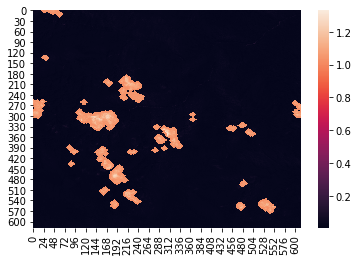

In [180]:
sns.heatmap(x[..., 0] + l.squeeze())

Text(0.5, 1.0, 'Histogram-equalized cloud-free image')

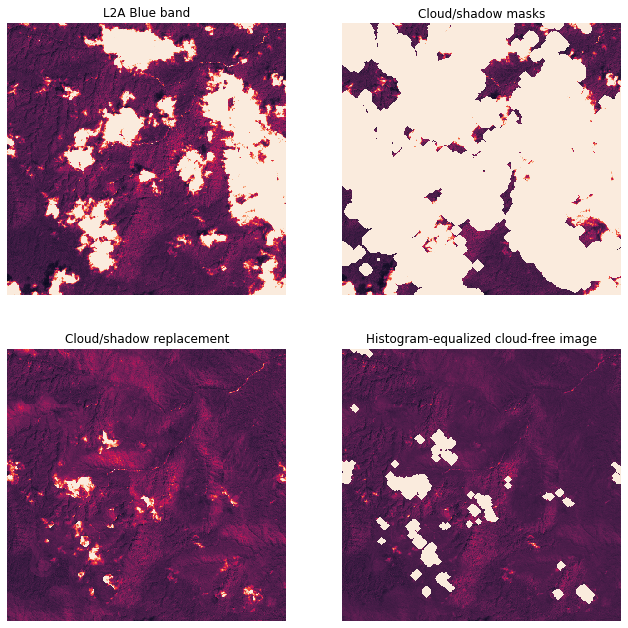

In [185]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (11, 11))
idx = 4
jagged = np.copy(t[idx])
jagged[y[idx] > 0] = x[y[idx] > 0]
sns.heatmap(t[idx, ..., 0], vmin = 0.0, vmax = 0.1, ax=ax1, cbar = False)
sns.heatmap(t[idx, ..., 0] + c[idx], vmin = 0.0, vmax = 0.1, ax=ax2, cbar = False)
sns.heatmap(jagged[..., 0], vmin = 0.0, vmax = 0.1, ax=ax3, cbar = False)
sns.heatmap(a[idx, ..., 0] + l.squeeze(),  vmin = 0.0,vmax = 0.1, ax=ax4, cbar = False)
ax1.set_title('L2A Blue band')
ax1.tick_params(left=False, bottom=False)
ax1.set(yticklabels=[], xticklabels=[])
ax2.tick_params(left=False, bottom=False)
ax2.set(yticklabels=[], xticklabels=[])
ax3.tick_params(left=False, bottom=False)
ax3.set(yticklabels=[], xticklabels=[])
ax4.tick_params(left=False, bottom=False)
ax4.set(yticklabels=[], xticklabels=[])
ax2.set_title('Cloud/shadow masks')
ax3.set_title('Cloud/shadow replacement')
ax4.set_title('Histogram-equalized cloud-free image')
#plt.show()
#fig.savefig('time0.png', dpi=150)

In [9]:
import imageio
images = []
filenames = ['time0.png', 'time1.png', 'time3.png', 'time4.png', 'time5.png']
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('out.gif', images, duration = 1.25)

In [23]:
def align_interp_array(interp_array, array, interp):

    def _water_ndwi(array):
        return (array[..., 1] - array[..., 3]) / (array[..., 1] + array[..., 3])

    water_mask = _water_ndwi(np.median(array, axis = 0)) > 0.0
    print(np.mean(water_mask), "% water")

    for time in range(array.shape[0]):
        if np.sum(interp[time] > 0) > 0 and np.sum(interp[time] == 0) > 0:
            if np.mean(interp[time] > 0) < 1:
                interp_map = interp[time, ...]
                interp_all = interp_map
                array_i = array[time]
                interp_array_i = interp_array[time]

                # Identify all of the areas that are, and aren't interpolated
                interp_areas = interp_array_i[np.logical_and(interp[time] > 0, water_mask == 0)]
                non_interp_areas = array_i[np.logical_and(interp[time] == 0,  water_mask == 0)]

                # And calculate their means and standard deviation per band
                std_src = bn.nanstd(interp_areas, axis = (0))
                std_ref = bn.nanstd(non_interp_areas, axis = (0))
                mean_src = bn.nanmean(interp_areas, axis = (0))
                mean_ref = bn.nanmean(non_interp_areas, axis = (0))
                std_mult = (std_ref / std_src)

                addition = (mean_ref - (mean_src * (std_mult)))
                interp_array_i[np.logical_and(interp[time] > 0, water_mask == 0)] = (
                        interp_array_i[np.logical_and(interp[time] > 0, water_mask == 0)] * std_mult + addition
                    )

                interp_areas = interp_array_i[np.logical_and(interp[time] > 0, water_mask == 1)]
                non_interp_areas = array_i[np.logical_and(interp[time] == 0,  water_mask == 1)]
                
                if interp_areas.shape[0] > 100 and non_interp_areas.shape[0] > 100:
                # And calculate their means and standard deviation per band
                    std_src = bn.nanstd(interp_areas, axis = (0))
                    std_ref = bn.nanstd(non_interp_areas, axis = (0))
                    mean_src = bn.nanmean(interp_areas, axis = (0))
                    mean_ref = bn.nanmean(non_interp_areas, axis = (0))
                    std_mult = (std_ref / std_src)

                    addition = (mean_ref - (mean_src * (std_mult)))
                    interp_array_i[np.logical_and(interp[time] > 0, water_mask == 1)] = (
                            interp_array_i[np.logical_and(interp[time] > 0, water_mask == 1)] * std_mult + addition
                        )
                
                interp_array[time] = interp_array_i

    for time in range(array.shape[0]):
        if np.mean(interp[time] > 0) == 1:
            candidate_lower = np.max([time - 1, 0])
            candidate_upper = np.min([time + 1, array.shape[0] - 1])
            candidate = np.mean(
                np.array([array[candidate_lower], array[candidate_upper]]), axis = 0
            )
            interp_array[time] = candidate

    return interp_array

In [25]:
interp_array = np.zeros_like(t, dtype = np.float32)
for date in range(0, t.shape[0]):
    interp_array[date, y[date] > 0] = x[y[date] > 0]
#l = align_interp_array()

<AxesSubplot:>

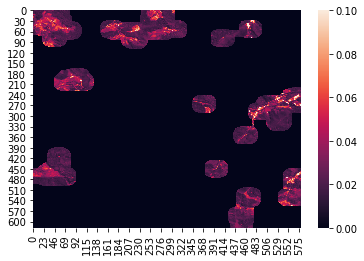

In [28]:
sns.heatmap(interp_array[6, ..., 0], vmax = 0.1)

<AxesSubplot:>

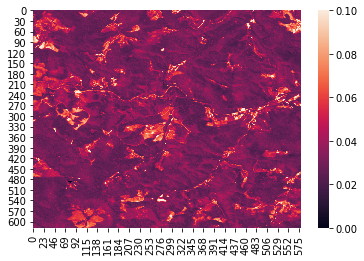

In [63]:
sns.heatmap((t[6, ..., 0] 0)

0.0010573596696797233 % water


<AxesSubplot:>

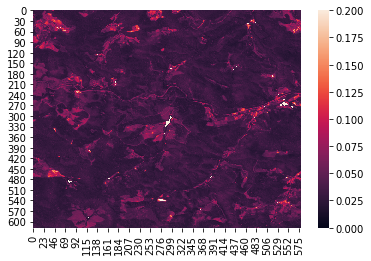

In [72]:
import bottleneck as bn
l = align_interp_array(interp_array, t, y)
#l = (t * (1 - y[..., np.newaxis]) +  \
#    (l * y[..., np.newaxis]))
sns.heatmap(t[6, ..., 0] + water_mask.squeeze(), vmax = 0.2, vmin = 0.0)

In [68]:
def _ndwi(arr):
        return (arr[..., 1] - arr[..., 3]) / (arr[..., 1] + arr[..., 3])
    
water_mask = _ndwi(t)
water_mask = np.median(water_mask, axis = 0)[np.newaxis]
water_mask = water_mask > 0
    


<AxesSubplot:>

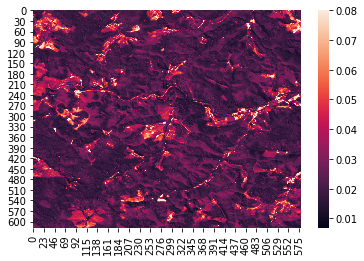

In [75]:
sns.heatmap(x[..., 0], vmax = 0.08)

In [111]:
def detect_pfcp(arr):
    
    def _ndbi(arr):
        return ((arr[..., 8] - arr[..., 3]) / (arr[..., 8] + arr[..., 3]))
    
    def _ndvi(arr):
        return (arr[..., 3] - arr[..., 2]) / (arr[..., 3] + arr[..., 2])
    
    def _ndwi(arr):
        return (arr[..., 1] - arr[..., 3]) / (arr[..., 1] + arr[..., 3])
    
    pfps = np.logical_and(_ndbi(arr) > 0, _ndbi(arr) > _ndvi(arr))
    water_mask = _ndwi(arr)
    water_mask = np.median(water_mask, axis = 0)[np.newaxis]
    water_mask = water_mask > 0

    pfps = np.logical_and(pfps, water_mask == 0)
    
    cdis = np.zeros((arr.shape[0], arr.shape[1], arr.shape[2]), dtype = np.float32)
    
    for time in range(arr.shape[0]):
        
        b8down = np.copy(arr[time, ..., 3])
        if (b8down.shape[0] % 2 + b8down.shape[1] % 2) > 0:
            b8down = resize(b8down, (b8down.shape[0] + b8down.shape[0] % 2, 
                                     b8down.shape[1] + b8down.shape[1] % 2), 0)
        b8down = ndimage.gaussian_filter(b8down, sigma = 0.5, truncate = 3)
        b8down = np.reshape(b8down, (b8down.shape[0] // 2, 2, b8down.shape[1] // 2, 2))
        b8down = np.mean(b8down, axis = (1, 3))
        
        b8adown = np.copy(arr[time, ..., 7])
        if (b8adown.shape[0] % 2 + b8adown.shape[1] % 2) > 0:
            b8adown = resize(b8adown, (b8adown.shape[0] + b8adown.shape[0] % 2, 
                                       b8adown.shape[1] + b8adown.shape[1] % 2), 0)
        b8adown = np.reshape(b8adown, (b8adown.shape[0] // 2, 2, b8adown.shape[1] // 2, 2))
        b8adown = np.mean(b8adown, axis = (1, 3))
        
        b7down = np.copy(arr[time, ..., 6])
        if (b7down.shape[0] % 2 + b7down.shape[1] % 2) > 0:
            b7down = resize(b7down, (b7down.shape[0] + b7down.shape[0] % 2, 
                                           b7down.shape[1] + b7down.shape[1] % 2), 0)
        b7down = np.reshape(b7down, (b7down.shape[0] // 2, 2, b7down.shape[1] // 2, 2))
        b7down = np.mean(b7down, axis = (1, 3))
        
        r8a = b8down / b8adown
        r8a7 = b7down / b8adown

        mean_op = np.ones((7,7))/(7*7)
        mean_of_sq = signal.convolve2d( r8a**2, mean_op, mode='same', boundary='symm')
        sq_of_mean = signal.convolve2d( r8a   , mean_op, mode='same', boundary='symm') **2
        r8a = mean_of_sq - sq_of_mean

        mean_of_sq = signal.convolve2d( r8a7**2, mean_op, mode='same', boundary='symm')
        sq_of_mean = signal.convolve2d( r8a7   , mean_op, mode='same', boundary='symm') **2
        r8a7 = mean_of_sq - sq_of_mean

        cdi = (r8a7 -r8a)/(r8a7 + r8a)
        pfcps = cdi >= -0.7
        pfcps = pfcps.repeat(2, axis = 0).repeat(2, axis = 1)
        pfcps = resize(pfcps, (arr.shape[1], arr.shape[2]), 0)
        cdis[time] = pfcps
        
    cdis = binary_dilation(cdis, iterations = 3)
    pfps = binary_dilation(pfps, iterations = 3)
        
    fcps = (pfps * cdis)
    return fcps, pfps


def remove_missed_clouds(img: np.ndarray) -> np.ndarray:
    """ Removes clouds that may have been missed by s2cloudless
        by looking at a temporal change outside of IQR

        Parameters:
         img (arr):

        Returns:
         to_remove (arr):
    """
    def _water_ndwi(array):
        # For wate rmasking
        return (array[..., 1] - array[..., 3]) / (array[..., 1] + array[..., 3])
    
    def _hollstein_cld(arr):
        # Simple cloud detection algorithm
        # Generates "okay" cloud masks that are to be refined
        # This step could probably be improved
        # From Figure 6 in Hollstein et al. 2016
        step1 = arr[..., 7] > 0.156
        step2b = arr[..., 1] > 0.28
        step3 = arr[..., 5] / arr[..., 8] < 4.292
        cl = step1 * step2b * step3# * step4
        for i in range(cl.shape[0]):
            cl[i] = binary_dilation(1 - (binary_dilation(cl[i] == 0, iterations = 2)), iterations = 10)
        return cl

    def _winsum(in_arr, windowsize):
        # Sums pixels in a moving window
        in_arr = np.pad(in_arr, windowsize//2, mode='reflect')
        in_arr[windowsize:] -= in_arr[:-windowsize]
        in_arr[:, windowsize:] -= in_arr[:, :-windowsize]
        return in_arr.cumsum(0)[windowsize-1:].cumsum(1)[:, windowsize-1:]

    water_mask = bn.nanmedian(_water_ndwi(img), axis = 0)
    shadows = np.empty_like(img[..., 0], dtype = np.float32)
    clouds = np.empty_like(shadows, dtype = np.float32)
    
    # Generate a "okay" quality cloud mask
    # and use it to do multi-temporal cloud shadow masking
    # Where the delta B8A and delta B11 are < -0.04 and B2 is < 0.095 over land
    # The water shadow thresholds work -okay- and could be improved
    clm = _hollstein_cld(img)
    for time in range(img.shape[0]):
        lower = np.max([0, time - 2])
        upper = np.min([img.shape[0], time + 3])
        others = np.array([x for x in np.arange(lower, upper)])

        ri_shadow = np.copy(img[..., [0, 1, 7, 8]])
        ri_shadow = ri_shadow[others]
        ri_shadow[clm[others] > 0] = np.nan
        # Failure case if the median non-cloud image is a shadow
        # Non-cloud-shadow 5-window temporall median
        ri_shadow = bn.nanmedian(ri_shadow, axis = 0)
        ri_shadow[np.isnan(ri_shadow)] = np.min(img[..., [0, 1, 7, 8]],
                                                    axis = 0)[np.isnan(ri_shadow)]

        deltab8a = (img[time, ..., 7] - ri_shadow[...,2]) < -0.04
        deltab11 = (img[time, ..., 8] - ri_shadow[..., 3]) < -0.04
        ti0 = (img[time, ..., 0] < 0.095)

        shadows_i = (deltab11 * deltab8a * ti0)
        shadows_i[water_mask > 0] = 0.

        water_shadow = ((img[time, ..., 0] - ri_shadow[..., 0]) < -0.04) * \
                        ((img[time, ..., 1] - ri_shadow[..., 1]) < -0.04) * \
                        (img[time, ..., 7] < 0.03) * \
                        ((ri_shadow[..., 1] - img[time, ..., 1]) > 0.008) * \
                        (water_mask > 0)
        shadows[time] = shadows_i + water_shadow

    # Erode and dilate the shadow mask to remove small shadows
    # and increase boundary detection of shadows
    struct2 = generate_binary_structure(2, 2)
    for i in range(clouds.shape[0]):
        shadows_i = shadows[i]
        shadows_i = binary_dilation(1 - (binary_dilation(shadows_i == 0, iterations = 5)), iterations = 8)
        shadows_i = distance(1 - shadows_i)
        shadows_i[shadows_i <= 5] = 0.
        shadows_i[shadows_i > 5] = 1
        shadows_i = 1 - shadows_i
        shadows[i] = shadows_i
    
    # Use the cloud shadow masks to generate cloud-shadow-free
    # seasonal / local composites. Use these to generate
    # multi-temporal cloud candidate masks
    for time in range(img.shape[0]):
        lower = np.max([0, time - 2])
        upper = np.min([img.shape[0], time + 3])
        
        if (upper - lower) == 3:
            if upper == img.shape[0]:
                lower = np.maximum(lower - 1, 0)
            if lower == 0:
                upper = np.minimum(upper + 1, img.shape[0])
        others = np.array([x for x in np.arange(lower, upper)]) #if x != time])
        close = [np.max([0, time - 1]), np.min([img.shape[0] - 1, time + 1])]
        if close[1] - close[0] < 2:
            if close[0] == 0:
                close[0] += 1
                close[1] += 1
            else:
                close[1] -= 1
                close[0] -= 1
        print(close)
        ri_ref  = np.copy(img[..., [0, 1, 2]])
        # Go through and remove the cloud shadows and 
        # generate a darkest visible non-shadow composite
        if img.shape[0] > 2:
            ri_ref[shadows > 0] = np.nan
            ri_upper0 = bn.nanmin(ri_ref[others, ..., 0], axis = 0)
            ri_upper1 = bn.nanmin(ri_ref[others, ..., 1], axis = 0)
            ri_upper2 = bn.nanmin(ri_ref[others, ..., 2], axis = 0)
            nan_replace = np.isnan(ri_upper0)
            ri_upper0[nan_replace] = np.percentile(ri_ref[..., 0], 25, axis = 0)[nan_replace]
            ri_upper1[nan_replace] = np.percentile(ri_ref[..., 1], 25, axis = 0)[nan_replace]
            ri_upper2[nan_replace] = np.percentile(ri_ref[..., 2], 25, axis = 0)[nan_replace]
            ri_close = bn.nanmin(ri_ref[close], axis = 0).astype(np.float32)
            ri_close[np.isnan(ri_close)] = np.min(img[..., :3], axis = 0)[np.isnan(ri_close)]
        else:
            ri_close = np.min(ri_ref[others], axis = 0).astype(np.float32)
            ri_upper0 = ri_close[..., 0]
            ri_upper1 = ri_close[..., 1]
            ri_upper2 = ri_close[..., 2]

        # In tropical broadleaf forests (which tend to have low visible reflectances),
        # small clouds can have red bands < 0.1 reflectance, and < 0.05 delta
        # So the seasonal delta thresholds are scaled based on the reference image as: 
            # reference b2    0 - 0.02 = 0.03
            # reference b2 0.02 - 0.04 = 0.04
            # reference b2 0.04 - 0.06 = 0.05
            # reference b2 0.06 - 0.08 = 0.06
            # reference b2      > 0.12 = 0.07
        # Note that this is not done in Candra et al. 2020 but empirically is useful
        # These thresholds are slightly aggressive and result in some commission errors
        # But don't seem to significantly affect the overall % of data coverage.
        close_thresh = np.minimum(((ri_close[..., 0] / 0.02 / 100) + 0.02), 0.07)
        close_thresh = np.maximum(close_thresh, 0.03)

        deltab2 = (img[time, ..., 0] - ri_upper0) > 0.08
        deltab3 = (img[time, ..., 1] - ri_upper1) > 0.07
        deltab4 = (img[time, ..., 2] - ri_upper2) > 0.07
        
        closeb2 = (img[time, ..., 0] - ri_close[..., 0]) > close_thresh
        closeb3 = (img[time, ..., 1] - ri_close[..., 1]) > close_thresh
        closeb4  = (img[time, ..., 2] - ri_close[..., 2]) > close_thresh
    
        clouds_i = (deltab2 * deltab3 * deltab4)
        clouds_close = (closeb2 * closeb3 * closeb4)
        clouds[time] = np.maximum(clouds_i, clouds_close)

    # Remove urban false positives using b8a, b7, b8 paralax effect
    # and NDBI, NDVI, NDWI
    # This method is from Fmask 4.0
    fcps, pfcps = detect_pfcp(img)
    clouds[fcps > 0] = 0.
    
    # Remove bright surface false positives e.g. sand, rock
    # With a NIR to SWIR1 ratio threshold of < 0.75
    # This threshold is from Fmask 4.0
    nir_swir_ratio = (img[..., 3] / (img[..., 8] + 0.01))
    nir_swir_ratio = nir_swir_ratio < 0.75
    nir_swir_ratio = binary_dilation(nir_swir_ratio, iterations = 3)
    for i in range(img.shape[0]):
        nir_swir_ratio[i][water_mask < 0] = 0.
    clouds[nir_swir_ratio] = 0.

    # Remove false positive clouds over water based on NIR
    # A large dilation is necessary here because of shorelines
    # This threshold is from Fmask 4.0
    for i in range(img.shape[0]):
        clouds_i = clouds[i]
        fp = (water_mask > 0) * (img[i, ..., 8] < 0.11)
        fp = binary_dilation(fp, iterations = 10)
        clouds_i[fp] = 0.
        clouds[i] = clouds_i

    # Finally, exclude where only minority of 3x3 win are clouds
    # As done in Fmask 4.0
    for i in range(clouds.shape[0]):
        window_sum = _winsum(clouds[i],  3)
        clouds[i][window_sum < 5] = 0.
    
    # Dilate the non-urban clouds, erode the urban clouds
    
    struct2 = generate_binary_structure(2, 2)
    struct3 = generate_binary_structure(3, 1)

    for i in range(clouds.shape[0]):
        pfcps[i] = binary_dilation(pfcps[i], iterations = 5)
        urban_clouds = clouds[i] * pfcps[i]
        urban_clouds = (1 - (binary_dilation(urban_clouds == 0, iterations = 3)))
        urban_clouds = binary_dilation(urban_clouds, iterations = 3)
        
        non_urban_clouds = clouds[i] * (1 - pfcps[i])
        #non_urban_clouds = (1 - (binary_dilation(non_urban_clouds == 0, iterations = 1)))
        window_sum = _winsum(non_urban_clouds,  3)
        is_large_cloud = np.copy(non_urban_clouds)
        is_large_cloud[window_sum < 8] = 0.
        is_small_cloud = np.copy(non_urban_clouds)
        is_small_cloud[window_sum >= 8] = 0.
        is_large_cloud = binary_dilation(is_large_cloud, iterations = 9)
        non_urban_clouds = np.maximum(is_large_cloud, is_small_cloud)

        #non_urban_clouds = binary_dilation(non_urban_clouds, iterations = 7, structure = struct2)
        non_urban_clouds = distance(1 - non_urban_clouds)
        non_urban_clouds[non_urban_clouds <= 3] = 0.
        non_urban_clouds[non_urban_clouds > 3] = 1
        non_urban_clouds = 1 - non_urban_clouds
        clouds[i] = (non_urban_clouds + urban_clouds)
        
    clouds = np.maximum(clouds, shadows)
    
    fcps = np.maximum(fcps, nir_swir_ratio)
    fcps = binary_dilation(fcps, iterations = 2)
    return clouds, fcps

In [112]:
import bottleneck as bn

cld, fcp = remove_missed_clouds(t)

[1, 2]
[0, 2]
[1, 3]
[2, 4]
[3, 5]
[4, 6]
[5, 7]
[6, 8]
[6, 7]


<AxesSubplot:>

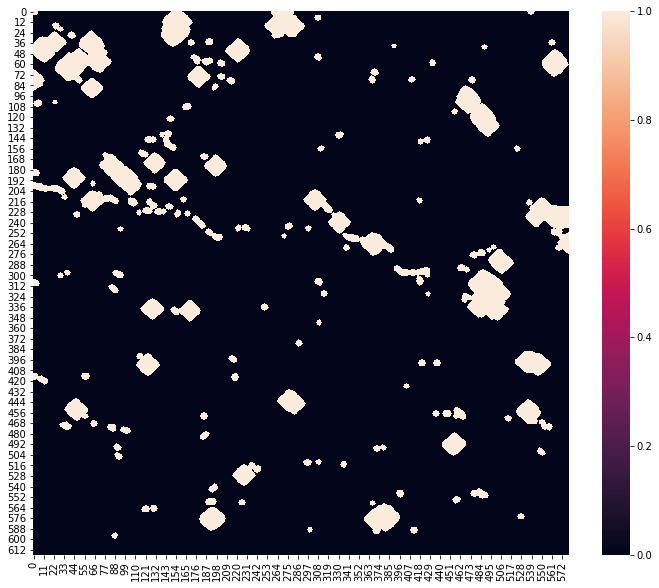

In [113]:
plt.figure(figsize=(12,10
                ))
sns.heatmap(cld[0])

<AxesSubplot:>

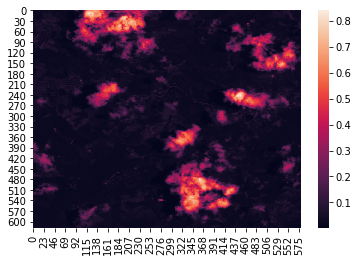

In [103]:
sns.heatmap(t[7, ..., 0])

In [178]:
(0.08 / 0.02 / 100) + 0.01

0.05